# Stock Market Analysis

In [53]:
# Import Modules

import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

## Read the data from Stock folder

### Check how much data is available? 

In [2]:
list = os.listdir("./Stocks/")
number_files = len(list)
print(number_files)

7196


### Choose 15 random stock data for analysis

In [3]:
#filenames = [x for x in os.listdir("./Stocks/") if x.endswith('.txt') and os.path.getsize(x) > 0]
filenames = random.sample([x for x in os.listdir("./Stocks/") if x.endswith('.txt') 
                           and os.path.getsize(os.path.join("./Stocks",x)) > 0], 15)
print(filenames)

['vygr.us.txt', 'bofil.us.txt', 'tgp_b.us.txt', 'wyigw.us.txt', 'dyn-ws-a.us.txt', 'vnda.us.txt', 'fr.us.txt', 'ego.us.txt', 'wbib.us.txt', 'hylb.us.txt', 'evr.us.txt', 'ecyt.us.txt', 'cve.us.txt', 'krg.us.txt', 'bml_l.us.txt']


### Read data into dataframes

In [4]:
data = []
for filename in filenames:
    df = pd.read_csv(os.path.join("./Stocks",filename), sep=',')
    label, _, _ = filename.split(sep='.')
    df['Label'] = label
    df['Date'] = pd.to_datetime(df['Date'])

    data.append(df)

In [5]:
data[0].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2015-11-11,15.10,17.93,14.75,17.75,1261000,0,vygr
1,2015-11-12,17.75,18.03,17.40,17.50,91900,0,vygr
2,2015-11-13,18.00,18.36,17.71,18.10,26900,0,vygr
3,2015-11-16,17.83,18.10,17.75,17.80,9300,0,vygr
4,2015-11-17,17.80,20.90,17.80,19.15,13900,0,vygr


In [6]:
print(len(data))

15


## Add various Technical Indicators in the dataframe

There are four types of Technical Indicators. Lets us take 4 sets of indicators and test which performs better in prediction of stock markets.
These 4 sets of Technical Indicators are:
- RSI, Volume (plain), Bollinger Bands, Aroon, Price Volume Trend, acceleration bands
- Stochastic, Chaikin Money Flow, Parabolic SAR, Rate of Change, Volume weighted average Price, momentum
- Commodity Channel Index, On Balance Volume, Keltner Channels, Triple Exponential Moving Average, Normalized Averager True Range ,directional movement indicators
- MACD, Money flowindex , Ichimoku, William %R, Volume MINMAX, adaptive moving average

In [7]:
# Create 4 copies of data to add columns of different sets of Technical Indicators
techindi1 = copy.deepcopy(data)
techindi2 = copy.deepcopy(data)
techindi3 = copy.deepcopy(data)
techindi4 = copy.deepcopy(data)

# techindi1 dataframe

### Calculation of Relative Strength Index (RSI)

In [8]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)


In [9]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)
for stock in range(len(techindi1)):
    techindi1[stock]['Momentum_1D'] = (techindi1[stock]['Close']-techindi1[stock]['Close'].shift(1)).fillna(0)
    techindi1[stock]['RSI_14D'] = techindi1[stock]['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
techindi1[0].tail(5)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-0.35,27.356613
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-3.16,21.578422
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-0.53,25.653437
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,0.58,28.646640
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,0.17,25.522954


### Calculation of Volume (Plain)

In [10]:
for stock in range(len(techindi1)):
    techindi1[stock]['Volume_plain'] = techindi1[stock]['Volume'].fillna(0)
techindi1[0].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-0.35,27.356613,412589
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-3.16,21.578422,1750358
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-0.53,25.653437,4735824
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,0.58,28.646640,1084037
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,0.17,25.522954,1005192


### Calculation of Bollinger Bands

In [11]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = pd.stats.moments.rolling_mean(price,length)
    sd = pd.stats.moments.rolling_std(price,length)
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [12]:
for stock in range(len(techindi1)):
    techindi1[stock]['BB_Middle_Band'], techindi1[stock]['BB_Upper_Band'], techindi1[stock]['BB_Lower_Band'] = bbands(techindi1[stock]['Close'], length=20, numsd=1)
    techindi1[stock]['BB_Middle_Band'] = techindi1[stock]['BB_Middle_Band'].fillna(0)
    techindi1[stock]['BB_Upper_Band'] = techindi1[stock]['BB_Upper_Band'].fillna(0)
    techindi1[stock]['BB_Lower_Band'] = techindi1[stock]['BB_Lower_Band'].fillna(0)
techindi1[0].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  after removing the cwd from sys.path.


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-0.35,27.356613,412589,21.440,23.653,19.227
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-3.16,21.578422,1750358,21.071,23.926,18.216
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-0.53,25.653437,4735824,20.513,23.819,17.208
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,0.58,28.646640,1084037,19.891,23.304,16.478
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,0.17,25.522954,1005192,19.560,23.249,15.872


### Calculation of Aroon Oscillator

In [13]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [241]:
for stock in range(len(techindi1)):
    listofzeros = [0] * 25
    up, down = aroon(techindi1[stock])
    aroon_list = [x - y for x, y in zip(up,down)]
    if len(aroon_list)==0:
        aroon_list = [0] * techindi1[stock].shape[0]
        techindi1[stock]['Aroon_Oscillator'] = aroon_list
    else:
        techindi1[stock]['Aroon_Oscillator'] = listofzeros+aroon_list


### Calculation of Price Volume Trend

PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT

In [15]:
for stock in range(len(techindi1)):
    techindi1[stock]["PVT"] = (techindi1[stock]['Momentum_1D']/ techindi1[stock]['Close'].shift(1))*techindi1[stock]['Volume']
    techindi1[stock]["PVT"] = techindi1[stock]["PVT"]-techindi1[stock]["PVT"].shift(1)
    techindi1[stock]["PVT"] = techindi1[stock]["PVT"].fillna(0)
techindi1[0].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-0.35,27.356613,412589,21.440,23.653,19.227,-60.0,90054.736437
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-3.16,21.578422,1750358,21.071,23.926,18.216,-60.0,-325859.586492
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-0.53,25.653437,4735824,20.513,23.819,17.208,-68.0,146816.957657
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,0.58,28.646640,1084037,19.891,23.304,16.478,-72.0,236521.726991
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,0.17,25.522954,1005192,19.560,23.249,15.872,-72.0,-36205.347131


### Calculation of Acceleration Bands

In [16]:
def abands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = pd.stats.moments.rolling_mean(price,length)
    sd = pd.stats.moments.rolling_std(price,length)
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [17]:
for stock in range(len(techindi1)):
    techindi1[stock]['BB_Middle_Band'], techindi1[stock]['BB_Upper_Band'], techindi1[stock]['BB_Lower_Band'] = bbands(techindi1[stock]['Close'], length=20, numsd=1)
    techindi1[stock]['BB_Middle_Band'] = techindi1[stock]['BB_Middle_Band'].fillna(0)
    techindi1[stock]['BB_Upper_Band'] = techindi1[stock]['BB_Upper_Band'].fillna(0)
    techindi1[stock]['BB_Lower_Band'] = techindi1[stock]['BB_Lower_Band'].fillna(0)
techindi1[0].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  after removing the cwd from sys.path.


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-0.35,27.356613,412589,21.440,23.653,19.227,-60.0,90054.736437
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-3.16,21.578422,1750358,21.071,23.926,18.216,-60.0,-325859.586492
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-0.53,25.653437,4735824,20.513,23.819,17.208,-68.0,146816.957657
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,0.58,28.646640,1084037,19.891,23.304,16.478,-72.0,236521.726991
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,0.17,25.522954,1005192,19.560,23.249,15.872,-72.0,-36205.347131


In [18]:
def abands(df):
    df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Upper_Band'] = pd.rolling_mean(df['aupband'], 20)
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Lower_Band'] = pd.rolling_mean(df['adownband'], 20)

In [19]:
for stock in range(len(techindi1)):
    abands(techindi1[stock])
    techindi1[stock] = techindi1[stock].fillna(0)
techindi1[0].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,...,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,aupband,AB_Upper_Band,adownband,AB_Lower_Band
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-0.35,27.356613,...,21.440,23.653,19.227,-60.0,90054.736437,21.4400,20.843755,26.576145,13.843755,17.081895
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-3.16,21.578422,...,21.071,23.926,18.216,-60.0,-325859.586492,21.0710,19.274189,26.390917,9.599189,16.662892
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-0.53,25.653437,...,20.513,23.819,17.208,-68.0,146816.957657,20.5135,17.383365,25.655219,8.733365,16.402194
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,0.58,28.646640,...,19.891,23.304,16.478,-72.0,236521.726991,19.8910,16.753050,25.055537,10.103050,15.817512
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,0.17,25.522954,...,19.560,23.249,15.872,-72.0,-36205.347131,19.5605,15.649267,23.874230,11.199267,15.886205


## Drop unwanted columns

In [20]:
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
for stock in range(len(techindi1)):
    techindi1[stock] = techindi1[stock].drop(labels = columns2Drop, axis=1)
techindi1[0].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
0,2015-11-11,15.10,17.93,14.75,17.75,1261000,0,vygr,0.0,1261000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,2015-11-12,17.75,18.03,17.40,17.50,91900,0,vygr,0.0,91900,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2015-11-13,18.00,18.36,17.71,18.10,26900,0,vygr,0.0,26900,0.0,0.0,0.0,0.0,2216.651911,0.0,0.0,0.0
3,2015-11-16,17.83,18.10,17.75,17.80,9300,0,vygr,0.0,9300,0.0,0.0,0.0,0.0,-1076.429361,0.0,0.0,0.0
4,2015-11-17,17.80,20.90,17.80,19.15,13900,0,vygr,0.0,13900,0.0,0.0,0.0,0.0,1208.357130,0.0,0.0,0.0


# techindi2 dataframe

### Calculation of Stochastic Oscillator (%K and %D)

In [21]:
def STOK(df, n):
    df['STOK'] = ((df['Close'] - pd.rolling_mean(df['Low'], n)) / (pd.rolling_max(df['High'], n) - pd.rolling_min(df['Low'],n))) * 100
    df['STOD'] = pd.rolling_mean(df['STOK'], 3)

In [22]:
for stock in range(len(techindi2)):
    STOK(techindi2[stock], 4)
    techindi2[stock] = techindi2[stock].fillna(0)
techindi2[0].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).min()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-26.708984,-30.173279
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-37.236574,-33.493331
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-23.860449,-29.268669
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,-2.533501,-21.210174
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,28.970126,0.858725


### Calculation of Chaikin Money Flow

In [23]:
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['Date']):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [24]:
for stock in range(len(techindi2)):
    listofzeros = [0] * 40
    CHMF = CMFlow(techindi2[stock], 20)
    if len(CHMF)==0:
        CHMF = [0] * techindi2[stock].shape[0]
        techindi2[stock]['Chaikin_MF'] = CHMF
    else:
        techindi2[stock]['Chaikin_MF'] = listofzeros+CHMF
techindi2[0].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-26.708984,-30.173279,-0.624592
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-37.236574,-33.493331,-0.950889
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-23.860449,-29.268669,-1.782791
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,-2.533501,-21.210174,-2.174636
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,28.970126,0.858725,-2.460878


### Calculation of Parabolic SAR

In [25]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull

In [26]:
for stock in range(len(techindi2)):
    psar(techindi2[stock])

techindi2[0].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar
500,2017-11-06,17.08,17.93,16.530,23.985164,412589,0,vygr,-26.708984,-30.173279,-0.624592,23.985164
501,2017-11-07,15.14,15.14,13.205,23.536654,1750358,0,vygr,-37.236574,-33.493331,-0.950889,23.536654
502,2017-11-08,11.96,13.69,11.960,22.710122,4735824,0,vygr,-23.860449,-29.268669,-1.782791,22.710122
503,2017-11-09,12.90,13.96,12.630,21.635110,1084037,0,vygr,-2.533501,-21.210174,-2.174636,21.635110
504,2017-11-10,13.19,13.81,12.920,20.667599,1005192,0,vygr,28.970126,0.858725,-2.460878,20.667599


### Calculation of Price Rate of Change

In [27]:
# ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100
for stock in range(len(techindi2)):
    techindi2[stock]['ROC'] = ((techindi2[stock]['Close'] - techindi2[stock]['Close'].shift(12))/(techindi2[stock]['Close'].shift(12)))*100
    techindi2[stock] = techindi2[stock].fillna(0)
techindi2[0].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC
500,2017-11-06,17.08,17.93,16.530,23.985164,412589,0,vygr,-26.708984,-30.173279,-0.624592,23.985164,-6.878164
501,2017-11-07,15.14,15.14,13.205,23.536654,1750358,0,vygr,-37.236574,-33.493331,-0.950889,23.536654,-8.216338
502,2017-11-08,11.96,13.69,11.960,22.710122,4735824,0,vygr,-23.860449,-29.268669,-1.782791,22.710122,-11.054926
503,2017-11-09,12.90,13.96,12.630,21.635110,1084037,0,vygr,-2.533501,-21.210174,-2.174636,21.635110,-14.903122
504,2017-11-10,13.19,13.81,12.920,20.667599,1005192,0,vygr,28.970126,0.858725,-2.460878,20.667599,-18.366712


### Calculation of Volume Weighted Average Price

In [28]:
for stock in range(len(techindi2)):
    techindi2[stock]['VWAP'] = np.cumsum(techindi2[stock]['Volume'] * (techindi2[stock]['High'] + techindi2[stock]['Low'])/2) / np.cumsum(techindi2[stock]['Volume'])
    techindi2[stock] = techindi2[stock].fillna(0)
techindi2[0].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP
500,2017-11-06,17.08,17.93,16.530,23.985164,412589,0,vygr,-26.708984,-30.173279,-0.624592,23.985164,-6.878164,15.032210
501,2017-11-07,15.14,15.14,13.205,23.536654,1750358,0,vygr,-37.236574,-33.493331,-0.950889,23.536654,-8.216338,15.008058
502,2017-11-08,11.96,13.69,11.960,22.710122,4735824,0,vygr,-23.860449,-29.268669,-1.782791,22.710122,-11.054926,14.853843
503,2017-11-09,12.90,13.96,12.630,21.635110,1084037,0,vygr,-2.533501,-21.210174,-2.174636,21.635110,-14.903122,14.829037
504,2017-11-10,13.19,13.81,12.920,20.667599,1005192,0,vygr,28.970126,0.858725,-2.460878,20.667599,-18.366712,14.807749


### Calculation of Momentum 

In [29]:
for stock in range(len(techindi2)):
    techindi2[stock]['Momentum'] = techindi2[stock]['Close'] - techindi2[stock]['Close'].shift(4)
    techindi2[stock] = techindi2[stock].fillna(0)
techindi2[0].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP,Momentum
500,2017-11-06,17.08,17.93,16.530,23.985164,412589,0,vygr,-26.708984,-30.173279,-0.624592,23.985164,-6.878164,15.032210,-0.927395
501,2017-11-07,15.14,15.14,13.205,23.536654,1750358,0,vygr,-37.236574,-33.493331,-0.950889,23.536654,-8.216338,15.008058,-1.279653
502,2017-11-08,11.96,13.69,11.960,22.710122,4735824,0,vygr,-23.860449,-29.268669,-1.782791,22.710122,-11.054926,14.853843,-2.011860
503,2017-11-09,12.90,13.96,12.630,21.635110,1084037,0,vygr,-2.533501,-21.210174,-2.174636,21.635110,-14.903122,14.829037,-2.827193
504,2017-11-10,13.19,13.81,12.920,20.667599,1005192,0,vygr,28.970126,0.858725,-2.460878,20.667599,-18.366712,14.807749,-3.317565


# techindi3 dataframe

### Calculation of Commodity Channel Index

In [30]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - pd.rolling_mean(TP, n)) / (constant * pd.rolling_std(TP,n))) #, name = 'CCI_' + str(n))
    return CCI

In [31]:
for stock in range(len(techindi3)):
    techindi3[stock]['CCI'] = CCI(techindi3[stock], 20, 0.015)
    techindi3[stock] = techindi3[stock].fillna(0)
techindi3[0].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI
500,2017-11-06,17.08,17.93,16.530,16.54,412589,0,vygr,-156.329410
501,2017-11-07,15.14,15.14,13.205,13.38,1750358,0,vygr,-188.721349
502,2017-11-08,11.96,13.69,11.960,12.85,4735824,0,vygr,-166.604683
503,2017-11-09,12.90,13.96,12.630,13.43,1084037,0,vygr,-134.538887
504,2017-11-10,13.19,13.81,12.920,13.60,1005192,0,vygr,-114.441999


### Calculation of On Balance Volume

            
If the closing price is above the prior close price then: 
Current OBV = Previous OBV + Current Volume

If the closing price is below the prior close price then: 
Current OBV = Previous OBV  -  Current Volume

If the closing prices equals the prior close price then:
Current OBV = Previous OBV (no change)

In [32]:
for stock in range(len(techindi3)):
    new = (techindi3[stock]['Volume'] * (~techindi3[stock]['Close'].diff().le(0) * 2 -1)).cumsum()
    techindi3[stock]['OBV'] = new
techindi3[5].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV
2912,2017-11-06,16.15,16.2000,15.700,15.775,269444,0,vnda,9.966662,6556693
2913,2017-11-07,15.80,15.9927,14.825,15.000,641874,0,vnda,-60.302183,5914819
2914,2017-11-08,14.20,14.7000,12.600,13.100,2737389,0,vnda,-201.796346,3177430
2915,2017-11-09,12.65,13.5500,12.650,13.250,788261,0,vnda,-175.795457,3965691
2916,2017-11-10,13.15,13.5000,12.850,13.150,466924,0,vnda,-143.734699,3498767


### Calcualtion of Keltner Channels

In [33]:
#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(pd.rolling_mean((df['High'] + df['Low'] + df['Close']) / 3, n), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(pd.rolling_mean((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3, n), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(pd.rolling_mean((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3, n), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

In [34]:
for stock in range(len(techindi3)):
    KelchM, KelchD, KelchU = KELCH(techindi3[stock], 14)
    techindi3[stock]['Kelch_Upper'] = KelchU
    techindi3[stock]['Kelch_Middle'] = KelchM
    techindi3[stock]['Kelch_Down'] = KelchD
    techindi3[stock] = techindi3[stock].fillna(0)
techindi3[5].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  """


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down
2912,2017-11-06,16.15,16.2000,15.700,15.775,269444,0,vnda,9.966662,6556693,16.204381,15.586202,14.968024
2913,2017-11-07,15.80,15.9927,14.825,15.000,641874,0,vnda,-60.302183,5914819,16.209424,15.533160,14.856895
2914,2017-11-08,14.20,14.7000,12.600,13.100,2737389,0,vnda,-201.796346,3177430,16.154662,15.356969,14.559276
2915,2017-11-09,12.65,13.5500,12.650,13.250,788261,0,vnda,-175.795457,3965691,16.003471,15.155779,14.308086
2916,2017-11-10,13.15,13.5000,12.850,13.150,466924,0,vnda,-143.734699,3498767,15.830852,14.965302,14.099752


### Calculation of Triple Exponential Moving Average

Triple Exponential MA Formula:

T-EMA = (3*EMA – 3*EMA(EMA)) + EMA(EMA(EMA))

Where:

EMA = EMA(1) + α * (Close – EMA(1))

α = 2 / (N + 1)

N = The smoothing period.

In [35]:
for stock in range(len(techindi3)):
    techindi3[stock]['EMA'] = pd.ewma(techindi3[stock]['Close'], span = 3)
    techindi3[stock] = techindi3[stock].fillna(0)

for stock in range(len(techindi3)):
    techindi3[stock]['TEMA'] = (3 * techindi3[stock]['EMA'] - 3 * techindi3[stock]['EMA'] * techindi3[stock]['EMA']) + (techindi3[stock]['EMA']*techindi3[stock]['EMA']*techindi3[stock]['EMA'])
techindi3[5].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,EMA,TEMA
2912,2017-11-06,16.15,16.2000,15.700,15.775,269444,0,vnda,9.966662,6556693,16.204381,15.586202,14.968024,15.788973,3235.551076
2913,2017-11-07,15.80,15.9927,14.825,15.000,641874,0,vnda,-60.302183,5914819,16.209424,15.533160,14.856895,15.394486,2983.555352
2914,2017-11-08,14.20,14.7000,12.600,13.100,2737389,0,vnda,-201.796346,3177430,16.154662,15.356969,14.559276,14.247243,2325.751429
2915,2017-11-09,12.65,13.5500,12.650,13.250,788261,0,vnda,-175.795457,3965691,16.003471,15.155779,14.308086,13.748622,2072.999707
2916,2017-11-10,13.15,13.5000,12.850,13.150,466924,0,vnda,-143.734699,3498767,15.830852,14.965302,14.099752,13.449311,1930.460654


### Calculation of Normalized Average True Range

True Range = Highest of (HIgh - low, abs(High - previous close), abs(low - previous close))

Average True Range = 14 day MA of True Range

Normalized Average True Range = ATR / Close * 100

In [36]:
for stock in range(len(techindi3)):
    techindi3[stock]['HL'] = techindi3[stock]['High'] - techindi3[stock]['Low']
    techindi3[stock]['absHC'] = abs(techindi3[stock]['High'] - techindi3[stock]['Close'].shift(1))
    techindi3[stock]['absLC'] = abs(techindi3[stock]['Low'] - techindi3[stock]['Close'].shift(1))
    techindi3[stock]['TR'] = techindi3[stock][['HL','absHC','absLC']].max(axis=1)
    techindi3[stock]['ATR'] = techindi3[stock]['TR'].rolling(window=14).mean()
    techindi3[stock]['NATR'] = (techindi3[stock]['ATR'] / techindi3[stock]['Close']) *100
    techindi3[stock] = techindi3[stock].fillna(0)
techindi3[5].tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,Kelch_Middle,Kelch_Down,EMA,TEMA,HL,absHC,absLC,TR,ATR,NATR
2912,2017-11-06,16.15,16.2000,15.700,15.775,269444,0,vnda,9.966662,6556693,...,15.586202,14.968024,15.788973,3235.551076,0.5000,0.1000,0.40,0.5000,0.636036,4.031922
2913,2017-11-07,15.80,15.9927,14.825,15.000,641874,0,vnda,-60.302183,5914819,...,15.533160,14.856895,15.394486,2983.555352,1.1677,0.2177,0.95,1.1677,0.694121,4.627476
2914,2017-11-08,14.20,14.7000,12.600,13.100,2737389,0,vnda,-201.796346,3177430,...,15.356969,14.559276,14.247243,2325.751429,2.1000,0.3000,2.40,2.4000,0.836979,6.389149
2915,2017-11-09,12.65,13.5500,12.650,13.250,788261,0,vnda,-175.795457,3965691,...,15.155779,14.308086,13.748622,2072.999707,0.9000,0.4500,0.45,0.9000,0.886979,6.694178
2916,2017-11-10,13.15,13.5000,12.850,13.150,466924,0,vnda,-143.734699,3498767,...,14.965302,14.099752,13.449311,1930.460654,0.6500,0.2500,0.40,0.6500,0.904836,6.880880


### Calculation of Average Directional Movement Index (ADX)

Calculating the DMI can actually be broken down into two parts. 
First, calculating the +DI and -DI, and second, calculating the ADX.

To calculate the +DI and -DI you need to find the +DM and -DM (Directional Movement). 
+DM and -DM are calculated using the High, Low and Close for each period. 
You can then calculate the following:

Current High - Previous High = UpMove
Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0
If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

Once you have the current +DM and -DM calculated, the +DM and -DM lines can be 
calculated and plotted based on the number of user defined periods.

+DI = 100 times Exponential Moving Average of (+DM / Average True Range)
-DI = 100 times Exponential Moving Average of (-DM / Average True Range)

Now that -+DX and -DX have been calculated, the last step is calculating the ADX.

ADX = 100 times the Exponential Moving Average of the Absolute Value of (+DI - -DI) / (+DI + -DI)

In [37]:
def DMI(df, period):
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * pd.ewma(df['PlusDM']/df['ATR'], span = period)
    df['minusDI'] = 100 * pd.ewma(df['MinusDM']/df['ATR'], span = period)

    df['ADX'] = 100 * pd.ewma(abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI'])), span = period)

In [38]:
for stock in range(len(techindi3)):
    DMI(techindi3[stock], 14)
    techindi3[stock] = techindi3[stock].fillna(0)
techindi3[5].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=14,min_periods=0,adjust=True,ignore_na=False).mean()
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,ATR,NATR,UpMove,DownMove,Zero,PlusDM,MinusDM,plusDI,minusDI,ADX
2912,2017-11-06,16.15,16.2000,15.700,15.775,269444,0,vnda,9.966662,6556693,...,0.636036,4.031922,0.0000,-0.250,0,0.0,0.000,26.023301,28.240693,41.625019
2913,2017-11-07,15.80,15.9927,14.825,15.000,641874,0,vnda,-60.302183,5914819,...,0.694121,4.627476,-0.2073,0.875,0,0.0,0.875,22.553528,41.283085,39.986995
2914,2017-11-08,14.20,14.7000,12.600,13.100,2737389,0,vnda,-201.796346,3177430,...,0.836979,6.389149,-1.2927,2.225,0,0.0,2.225,19.546391,71.223627,42.246336
2915,2017-11-09,12.65,13.5500,12.650,13.250,788261,0,vnda,-175.795457,3965691,...,0.886979,6.694178,-1.1500,-0.050,0,0.0,0.000,16.940205,61.727144,44.204432
2916,2017-11-10,13.15,13.5000,12.850,13.150,466924,0,vnda,-143.734699,3498767,...,0.904836,6.880880,-0.0500,-0.200,0,0.0,0.000,14.681511,53.496858,45.901448


## Drop Unwanted Columns

In [39]:
columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']
for stock in range(len(techindi3)):
    techindi3[stock] = techindi3[stock].drop(labels = columns2Drop, axis=1)
techindi3[2].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,TEMA,NATR,plusDI,minusDI,ADX
0,2017-10-25,25.01,25.0200,24.65,24.8000,448855,0,tgp_b,0.0,448855,0.0,0.0,0.0,13482.272000,0.0,0.0,0.0,0.0
1,2017-10-26,24.82,24.8834,24.66,24.8391,275269,0,tgp_b,0.0,724124,0.0,0.0,0.0,13526.616140,0.0,0.0,0.0,0.0
2,2017-10-27,24.80,24.9000,24.80,24.8800,180246,0,tgp_b,0.0,904370,0.0,0.0,0.0,13579.170265,0.0,0.0,0.0,0.0
3,2017-10-30,24.98,24.9800,24.78,24.7800,152240,0,tgp_b,0.0,752130,0.0,0.0,0.0,13509.275211,0.0,0.0,0.0,0.0
4,2017-10-31,24.82,24.9400,24.76,24.9400,154146,0,tgp_b,0.0,906276,0.0,0.0,0.0,13618.575738,0.0,0.0,0.0,0.0


# techindi4 dataframe

### Calculation of MACD

MACD: (12-day EMA - 26-day EMA)

In [40]:
for stock in range(len(techindi4)):
    techindi4[stock]['26_ema'] = pd.ewma(techindi4[stock]['Close'], span=26)
    techindi4[stock]['12_ema'] = pd.ewma(techindi4[stock]['Close'], span = 12)
    techindi4[stock]['MACD'] = techindi4[stock]['12_ema'] - techindi4[stock]['26_ema']
    techindi4[stock] = techindi4[stock].fillna(0)
techindi4[2].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD
8,2017-11-06,24.78,24.8800,24.78,24.8500,78885,0,tgp_b,24.854739,24.854988,0.000249
9,2017-11-07,24.88,24.9145,24.79,24.7900,158919,0,tgp_b,24.845805,24.842673,-0.003133
10,2017-11-08,24.81,24.8250,24.73,24.7500,62763,0,tgp_b,24.833379,24.825716,-0.007663
11,2017-11-09,24.73,24.7600,24.61,24.7166,114477,0,tgp_b,24.819031,24.806316,-0.012716
12,2017-11-10,24.72,24.8590,24.72,24.7500,36009,0,tgp_b,24.810944,24.796537,-0.014407


### Calculation of Money Flow Index

Typical Price = (High + Low + Close)/3

Raw Money Flow = Typical Price x Volume

The money flow is divided into positive and negative money flow.

- Positive money flow is calculated by adding the money flow of all the days where the typical price is higher than the previous day's typical price.
- Negative money flow is calculated by adding the money flow of all the days where the typical price is lower than the previous day's typical price.
- If typical price is unchanged then that day is discarded.

Money Flow Ratio = (14-period Positive Money Flow)/(14-period Negative Money Flow)

Money Flow Index = 100 - 100/(1 + Money Flow Ratio)

In [41]:
def MFI(df):
    # typical price
    df['tp'] = (df['High']+df['Low']+df['Close'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['Volume']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = pd.rolling_sum(df['pmf'], 14, center=False)/pd.rolling_sum(df['nmf'], 14, center=False)
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])

In [42]:
for stock in range(len(techindi4)):
    MFI(techindi4[stock])
    techindi4[stock] = techindi4[stock].fillna(0)
techindi4[2].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).sum()
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD,tp,rmf,pmf,nmf,mfr,Money_Flow_Index
8,2017-11-06,24.78,24.8800,24.78,24.8500,78885,0,tgp_b,24.854739,24.854988,0.000249,24.836667,1.959240e+06,24.836667,0.000000,0.0,0.0
9,2017-11-07,24.88,24.9145,24.79,24.7900,158919,0,tgp_b,24.845805,24.842673,-0.003133,24.831500,3.946197e+06,0.000000,24.831500,0.0,0.0
10,2017-11-08,24.81,24.8250,24.73,24.7500,62763,0,tgp_b,24.833379,24.825716,-0.007663,24.768333,1.554535e+06,0.000000,24.768333,0.0,0.0
11,2017-11-09,24.73,24.7600,24.61,24.7166,114477,0,tgp_b,24.819031,24.806316,-0.012716,24.695533,2.827071e+06,0.000000,24.695533,0.0,0.0
12,2017-11-10,24.72,24.8590,24.72,24.7500,36009,0,tgp_b,24.810944,24.796537,-0.014407,24.776333,8.921710e+05,24.776333,0.000000,0.0,0.0


### Calculations of Ichimoku Cloud

Turning Line = ( Highest High + Lowest Low
 ) / 2, for the past 9 days

Standard Line = ( Highest High + Lowest Low
 ) / 2, for the past 26 days

Leading Span 1 = ( Standard Line + Turning
 Line ) / 2, plotted 26 days ahead of today

Leading Span 2 = ( Highest High + Lowest
 Low ) / 2, for the past 52 days, plotted 26 days ahead of today

Cloud = Shaded Area between Span 1 and Span
 2

In [43]:
def ichimoku(df):
    # Turning Line
    period9_high = pd.rolling_max(df['High'], window=9)
    period9_low = pd.rolling_min(df['Low'], window=9)
    df['turning_line'] = (period9_high + period9_low) / 2
    
    # Standard Line
    period26_high = pd.rolling_max(df['High'], window=26)
    period26_low = pd.rolling_min(df['Low'], window=26)
    df['standard_line'] = (period26_high + period26_low) / 2
    
    # Leading Span 1
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line']) / 2).shift(26)
    
    # Leading Span 2
    period52_high = pd.rolling_max(df['High'], window=52)
    period52_low = pd.rolling_min(df['Low'], window=52)
    df['ichimoku_span2'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 22 time periods behind (optional)
    df['chikou_span'] = df['Close'].shift(-22) # 22 according to investopedia

In [44]:
for stock in range(len(techindi4)):
    ichimoku(techindi4[stock])
    techindi4[stock] = techindi4[stock].fillna(0)
techindi4[2].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).max()
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).min()
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).min()
 

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,rmf,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span
8,2017-11-06,24.78,24.8800,24.78,24.8500,78885,0,tgp_b,24.854739,24.854988,...,1.959240e+06,24.836667,0.000000,0.0,0.0,24.835,0.0,0.0,0.0,0.0
9,2017-11-07,24.88,24.9145,24.79,24.7900,158919,0,tgp_b,24.845805,24.842673,...,3.946197e+06,0.000000,24.831500,0.0,0.0,24.830,0.0,0.0,0.0,0.0
10,2017-11-08,24.81,24.8250,24.73,24.7500,62763,0,tgp_b,24.833379,24.825716,...,1.554535e+06,0.000000,24.768333,0.0,0.0,24.865,0.0,0.0,0.0,0.0
11,2017-11-09,24.73,24.7600,24.61,24.7166,114477,0,tgp_b,24.819031,24.806316,...,2.827071e+06,0.000000,24.695533,0.0,0.0,24.805,0.0,0.0,0.0,0.0
12,2017-11-10,24.72,24.8590,24.72,24.7500,36009,0,tgp_b,24.810944,24.796537,...,8.921710e+05,24.776333,0.000000,0.0,0.0,24.805,0.0,0.0,0.0,0.0


### Calculation of William %R

%R = -100 * ( ( Highest High - Close) / (
 Highest High - Lowest Low ) )

In [45]:
def WillR(df):
    highest_high = pd.rolling_max(df['High'], window=14)
    lowest_low = pd.rolling_min(df['Low'], window=14)
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))


In [46]:
for stock in range(len(techindi4)):
    WillR(techindi4[stock])
    techindi4[stock] = techindi4[stock].fillna(0)
techindi4[2].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).max()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).min()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR
8,2017-11-06,24.78,24.8800,24.78,24.8500,78885,0,tgp_b,24.854739,24.854988,...,24.836667,0.000000,0.0,0.0,24.835,0.0,0.0,0.0,0.0,0.0
9,2017-11-07,24.88,24.9145,24.79,24.7900,158919,0,tgp_b,24.845805,24.842673,...,0.000000,24.831500,0.0,0.0,24.830,0.0,0.0,0.0,0.0,0.0
10,2017-11-08,24.81,24.8250,24.73,24.7500,62763,0,tgp_b,24.833379,24.825716,...,0.000000,24.768333,0.0,0.0,24.865,0.0,0.0,0.0,0.0,0.0
11,2017-11-09,24.73,24.7600,24.61,24.7166,114477,0,tgp_b,24.819031,24.806316,...,0.000000,24.695533,0.0,0.0,24.805,0.0,0.0,0.0,0.0,0.0
12,2017-11-10,24.72,24.8590,24.72,24.7500,36009,0,tgp_b,24.810944,24.796537,...,24.776333,0.000000,0.0,0.0,24.805,0.0,0.0,0.0,0.0,0.0


### Calculation of MINMAX

In [47]:
def MINMAX(df):
    df['MIN_Volume'] = pd.rolling_min(df['Volume'], window=14)
    df['MAX_Volume'] = pd.rolling_max(df['Volume'], window=14)

In [48]:
for stock in range(len(techindi4)):
    MINMAX(techindi4[stock])
    techindi4[stock] = techindi4[stock].fillna(0)
techindi4[8].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).min()
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).max()
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume
802,2017-11-06,25.4400,25.4999,25.4300,25.4999,11393,0,wbib,25.405857,25.547991,...,1.340271,57.269899,25.58130,25.4825,24.64275,24.55000,0.0,-54.000000,2470.0,19616.0
803,2017-11-07,25.3267,25.3267,25.1450,25.1906,6816,0,wbib,25.389912,25.493008,...,1.007499,50.186766,25.47500,25.4750,24.72145,24.55000,0.0,-93.090909,2470.0,19616.0
804,2017-11-08,25.1250,25.2199,25.0550,25.2199,4198,0,wbib,25.377319,25.450991,...,1.008848,50.220228,25.43000,25.4300,24.73375,24.55000,0.0,-78.013333,2470.0,19616.0
805,2017-11-09,25.1900,25.1900,25.0000,25.0000,4759,0,wbib,25.349369,25.381608,...,0.757595,43.104056,25.35000,25.4025,24.78520,24.55000,0.0,-100.000000,2470.0,19616.0
806,2017-11-10,25.0400,25.1099,25.0328,25.0650,5579,0,wbib,25.328305,25.332899,...,1.008678,50.216006,25.31995,25.4025,24.85020,24.55045,0.0,-91.925466,2470.0,19616.0


### Calculation of Adaptive Moving Average

In [49]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = pd.stats.moments.rolling_sum(absDiffx,n)
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

In [50]:
for stock in range(len(techindi4)):
    techindi4[stock]['KAMA'] = KAMA(techindi4[stock]['Close'])
    techindi4[stock] = techindi4[stock].fillna(0)
techindi4[8].tail()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).sum()
  


,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
802,2017-11-06,25.4400,25.4999,25.4300,25.4999,11393,0,wbib,25.405857,25.547991,...,57.269899,25.58130,25.4825,24.64275,24.55000,0.0,-54.000000,2470.0,19616.0,25.527678
803,2017-11-07,25.3267,25.3267,25.1450,25.1906,6816,0,wbib,25.389912,25.493008,...,50.186766,25.47500,25.4750,24.72145,24.55000,0.0,-93.090909,2470.0,19616.0,25.506744
804,2017-11-08,25.1250,25.2199,25.0550,25.2199,4198,0,wbib,25.377319,25.450991,...,50.220228,25.43000,25.4300,24.73375,24.55000,0.0,-78.013333,2470.0,19616.0,25.495512
805,2017-11-09,25.1900,25.1900,25.0000,25.0000,4759,0,wbib,25.349369,25.381608,...,43.104056,25.35000,25.4025,24.78520,24.55000,0.0,-100.000000,2470.0,19616.0,25.434784
806,2017-11-10,25.0400,25.1099,25.0328,25.0650,5579,0,wbib,25.328305,25.332899,...,50.216006,25.31995,25.4025,24.85020,24.55045,0.0,-91.925466,2470.0,19616.0,25.394790


## Drop Unwanted Columns

In [51]:
columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']
for stock in range(len(techindi3)):
    techindi4[stock] = techindi4[stock].drop(labels = columns2Drop, axis=1)
techindi4[2].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,MACD,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
0,2017-10-25,25.01,25.0200,24.65,24.8000,448855,0,tgp_b,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-10-26,24.82,24.8834,24.66,24.8391,275269,0,tgp_b,0.000877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-10-27,24.80,24.9000,24.80,24.8800,180246,0,tgp_b,0.002386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-10-30,24.98,24.9800,24.78,24.7800,152240,0,tgp_b,-0.000597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-10-31,24.82,24.9400,24.76,24.9400,154146,0,tgp_b,0.004162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Visualization of some technical indicators

## Visualization of techindi1

In [52]:
# check one dataframe
techindi1[2].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
0,2017-10-25,25.01,25.0200,24.65,24.8000,448855,0,tgp_b,0.0,448855,0.0,0.0,0.0,0,0.000000,0.0,0.0,0.0
1,2017-10-26,24.82,24.8834,24.66,24.8391,275269,0,tgp_b,0.0,275269,0.0,0.0,0.0,0,0.000000,0.0,0.0,0.0
2,2017-10-27,24.80,24.9000,24.80,24.8800,180246,0,tgp_b,0.0,180246,0.0,0.0,0.0,0,-137.200044,0.0,0.0,0.0
3,2017-10-30,24.98,24.9800,24.78,24.7800,152240,0,tgp_b,0.0,152240,0.0,0.0,0.0,0,-908.689719,0.0,0.0,0.0
4,2017-10-31,24.82,24.9400,24.76,24.9400,154146,0,tgp_b,0.0,154146,0.0,0.0,0.0,0,1607.190084,0.0,0.0,0.0


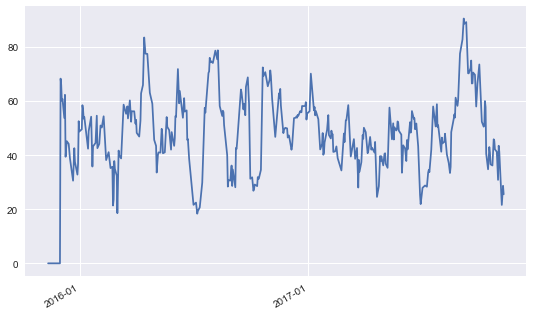

In [168]:
%matplotlib inline
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(techindi1[0]['Date'], techindi1[0]['RSI_14D'])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# format the coords message box
def price(x):
    return '$%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

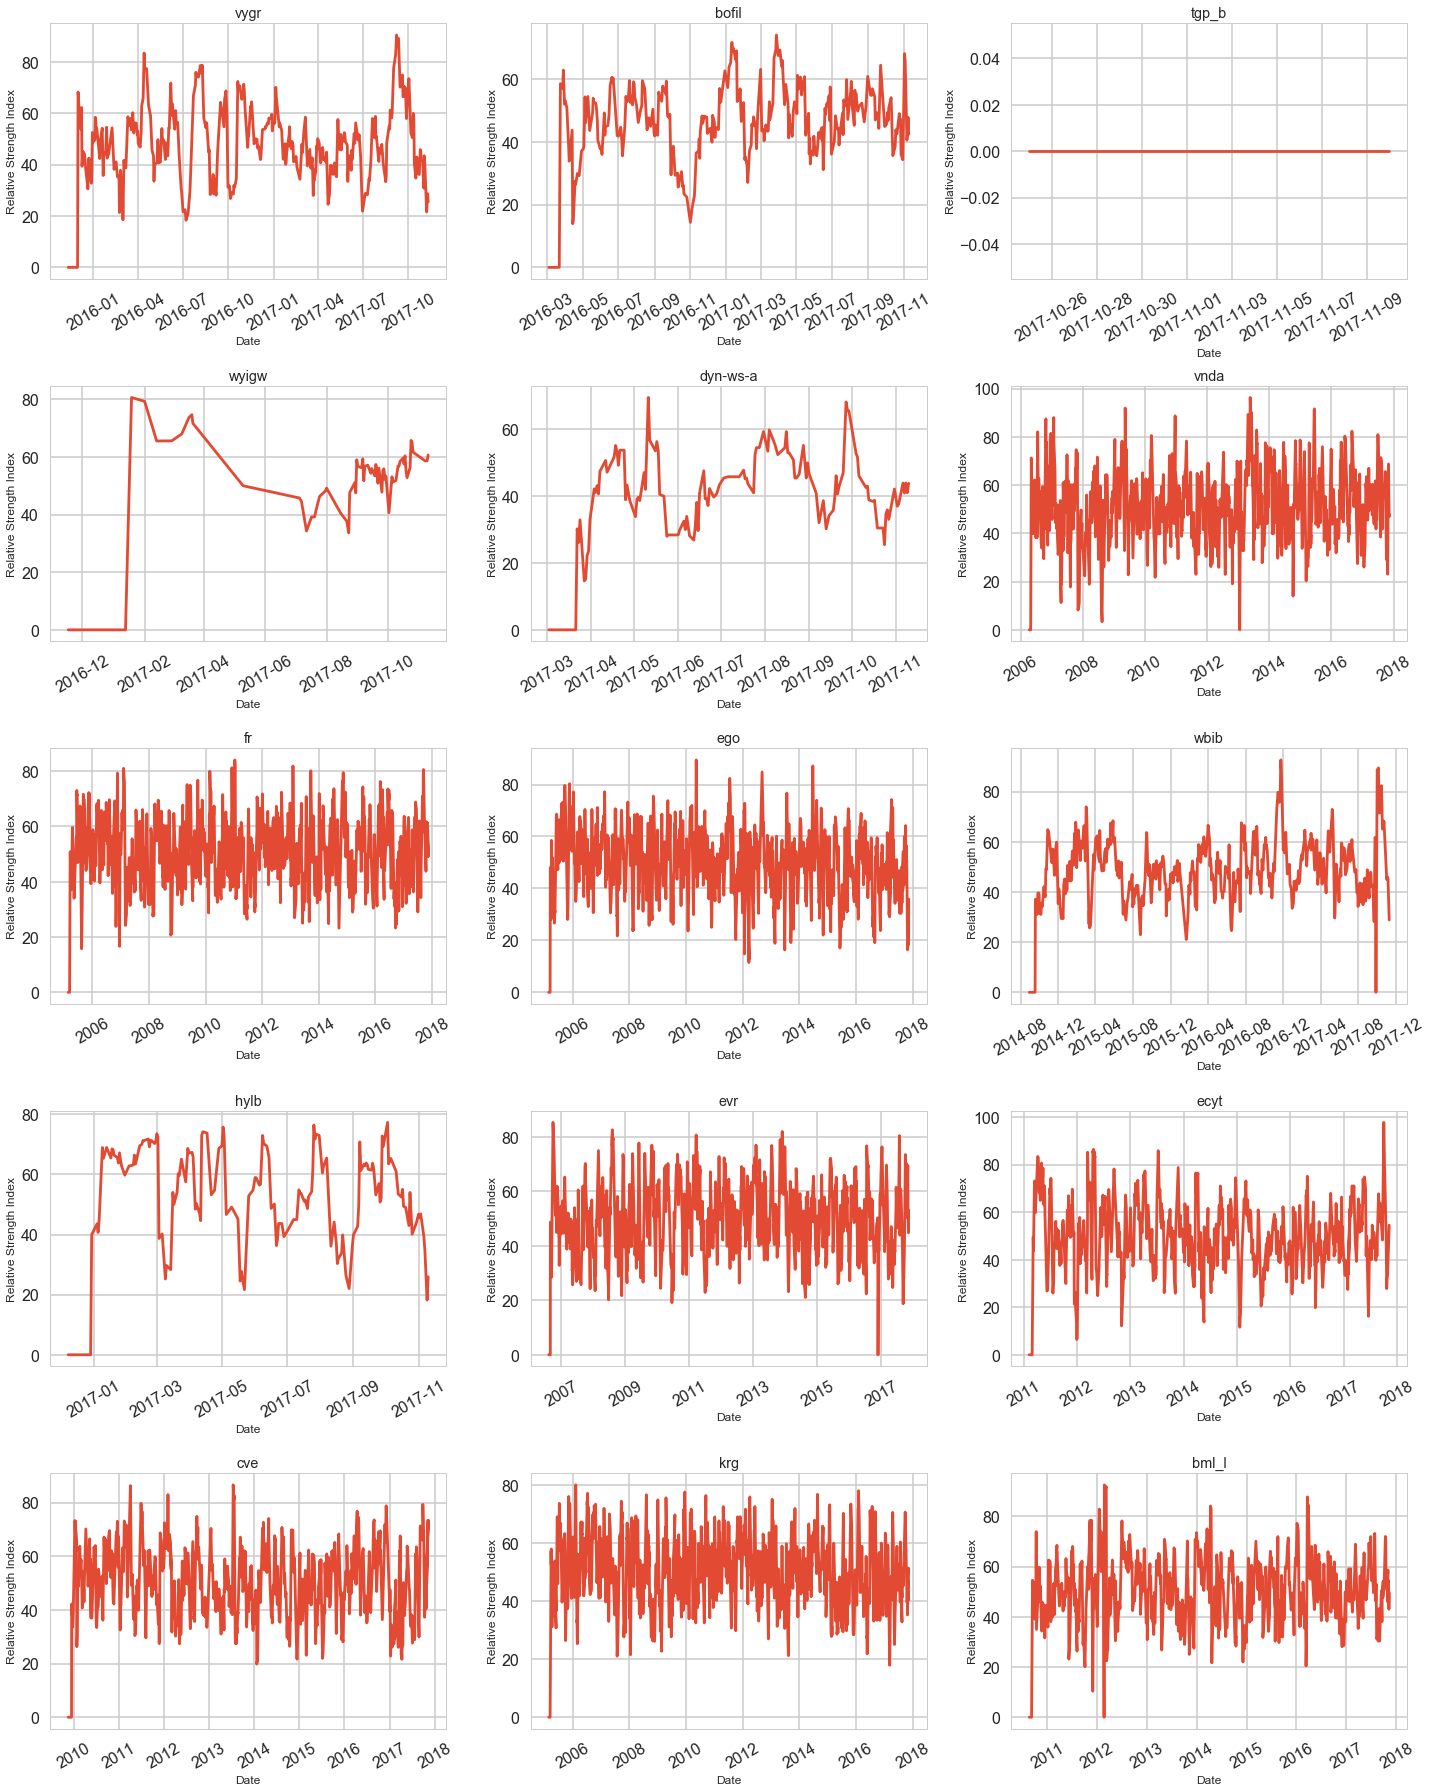

In [213]:
# RSI Plot

fig = plt.figure(figsize=(20,25))
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.plot(techindi1[i]['Date'], techindi1[i]['RSI_14D'])
    ax.set_title(str(techindi1[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Relative Strength Index")
    plt.xticks(rotation=30)
fig.tight_layout()


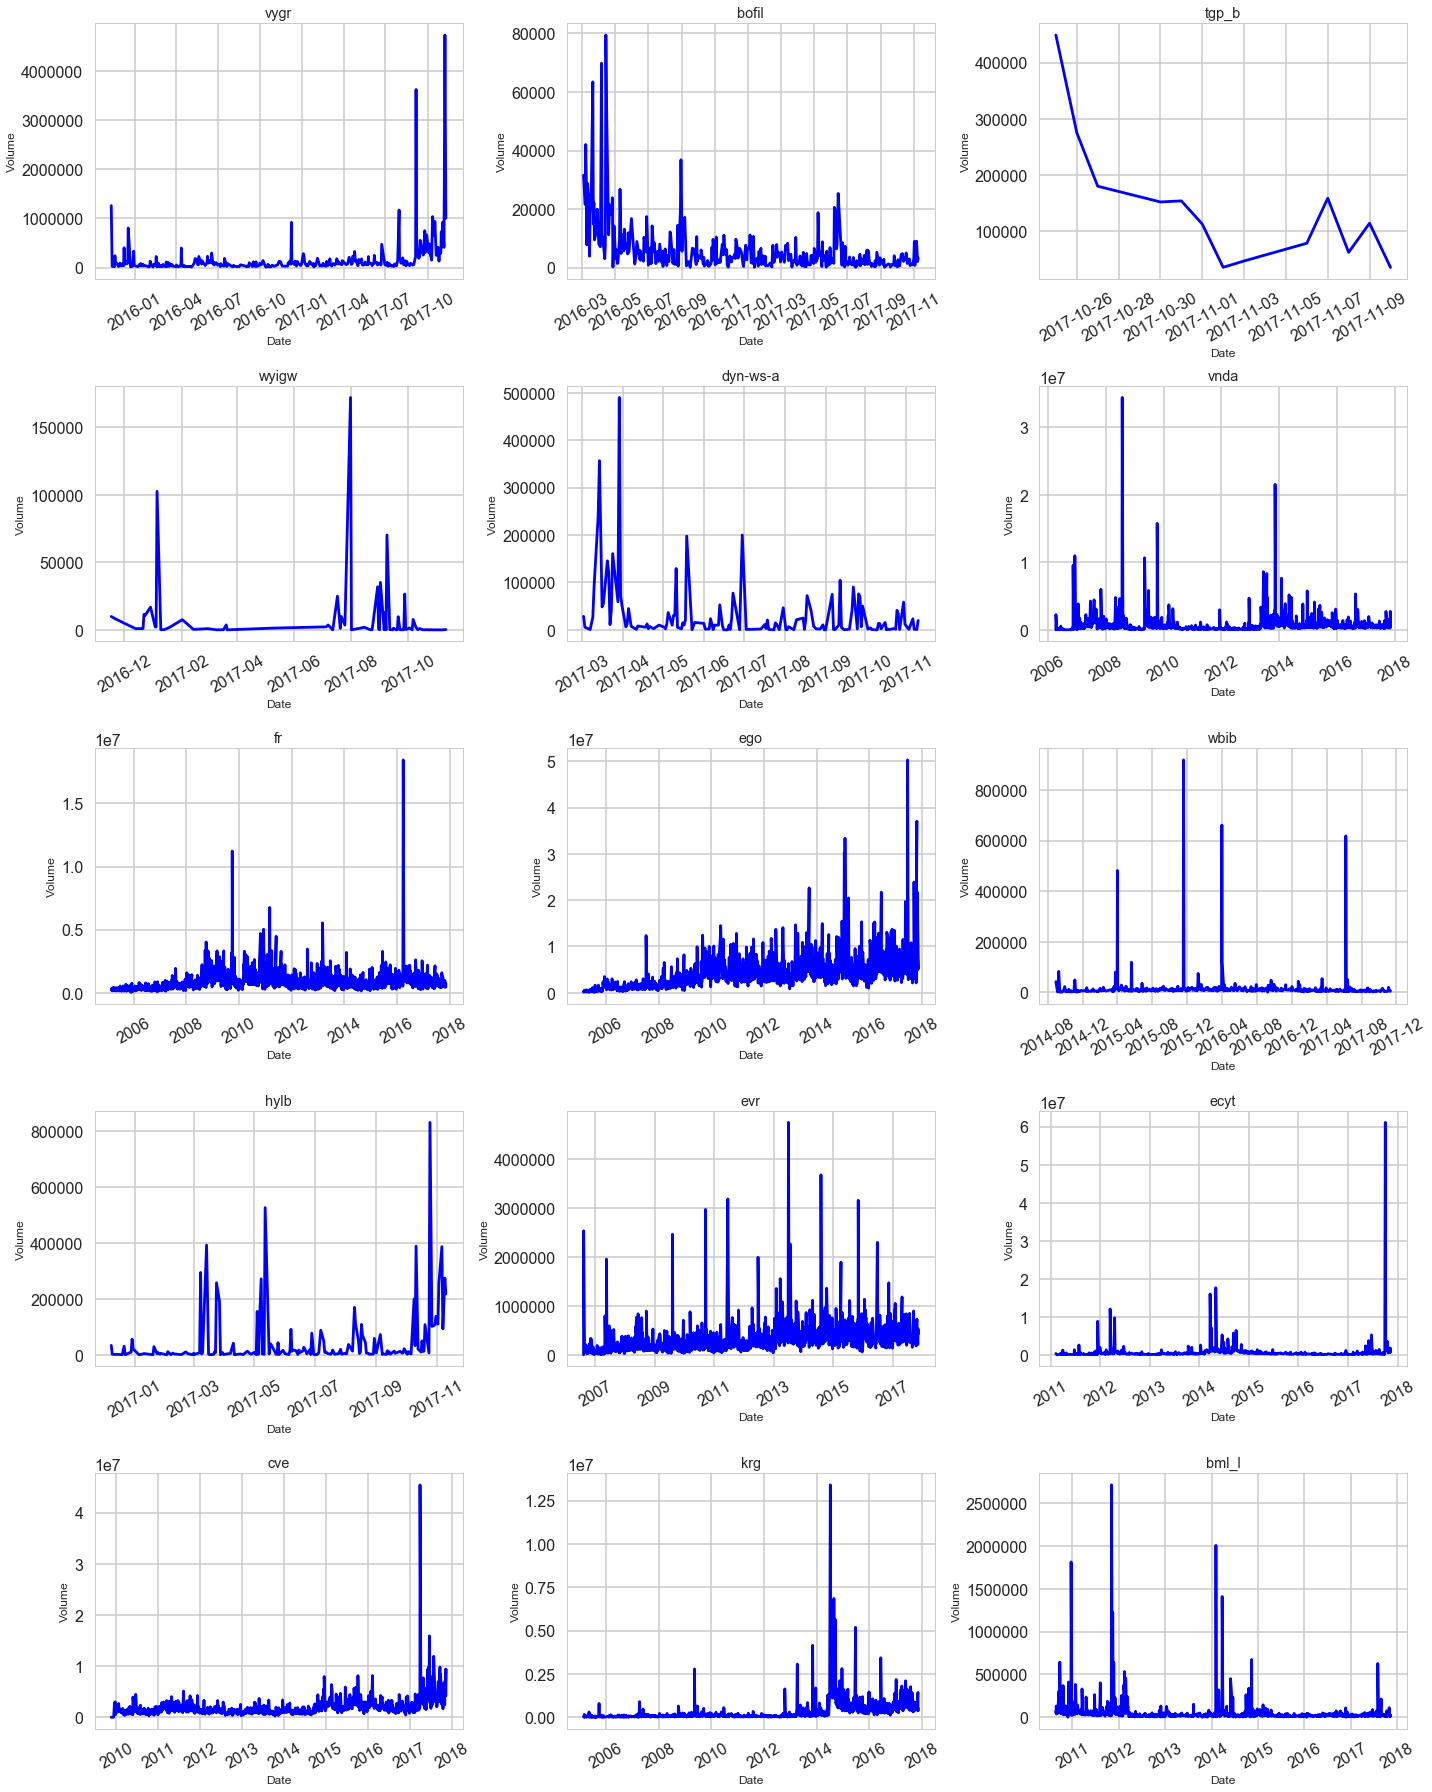

In [218]:
# Volume Plain plot
fig = plt.figure(figsize=(20,25))
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.plot(techindi1[i]['Date'], techindi1[i]['Volume_plain'], 'b')
    ax.set_title(str(techindi1[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Volume")
    plt.xticks(rotation=30)
fig.tight_layout()

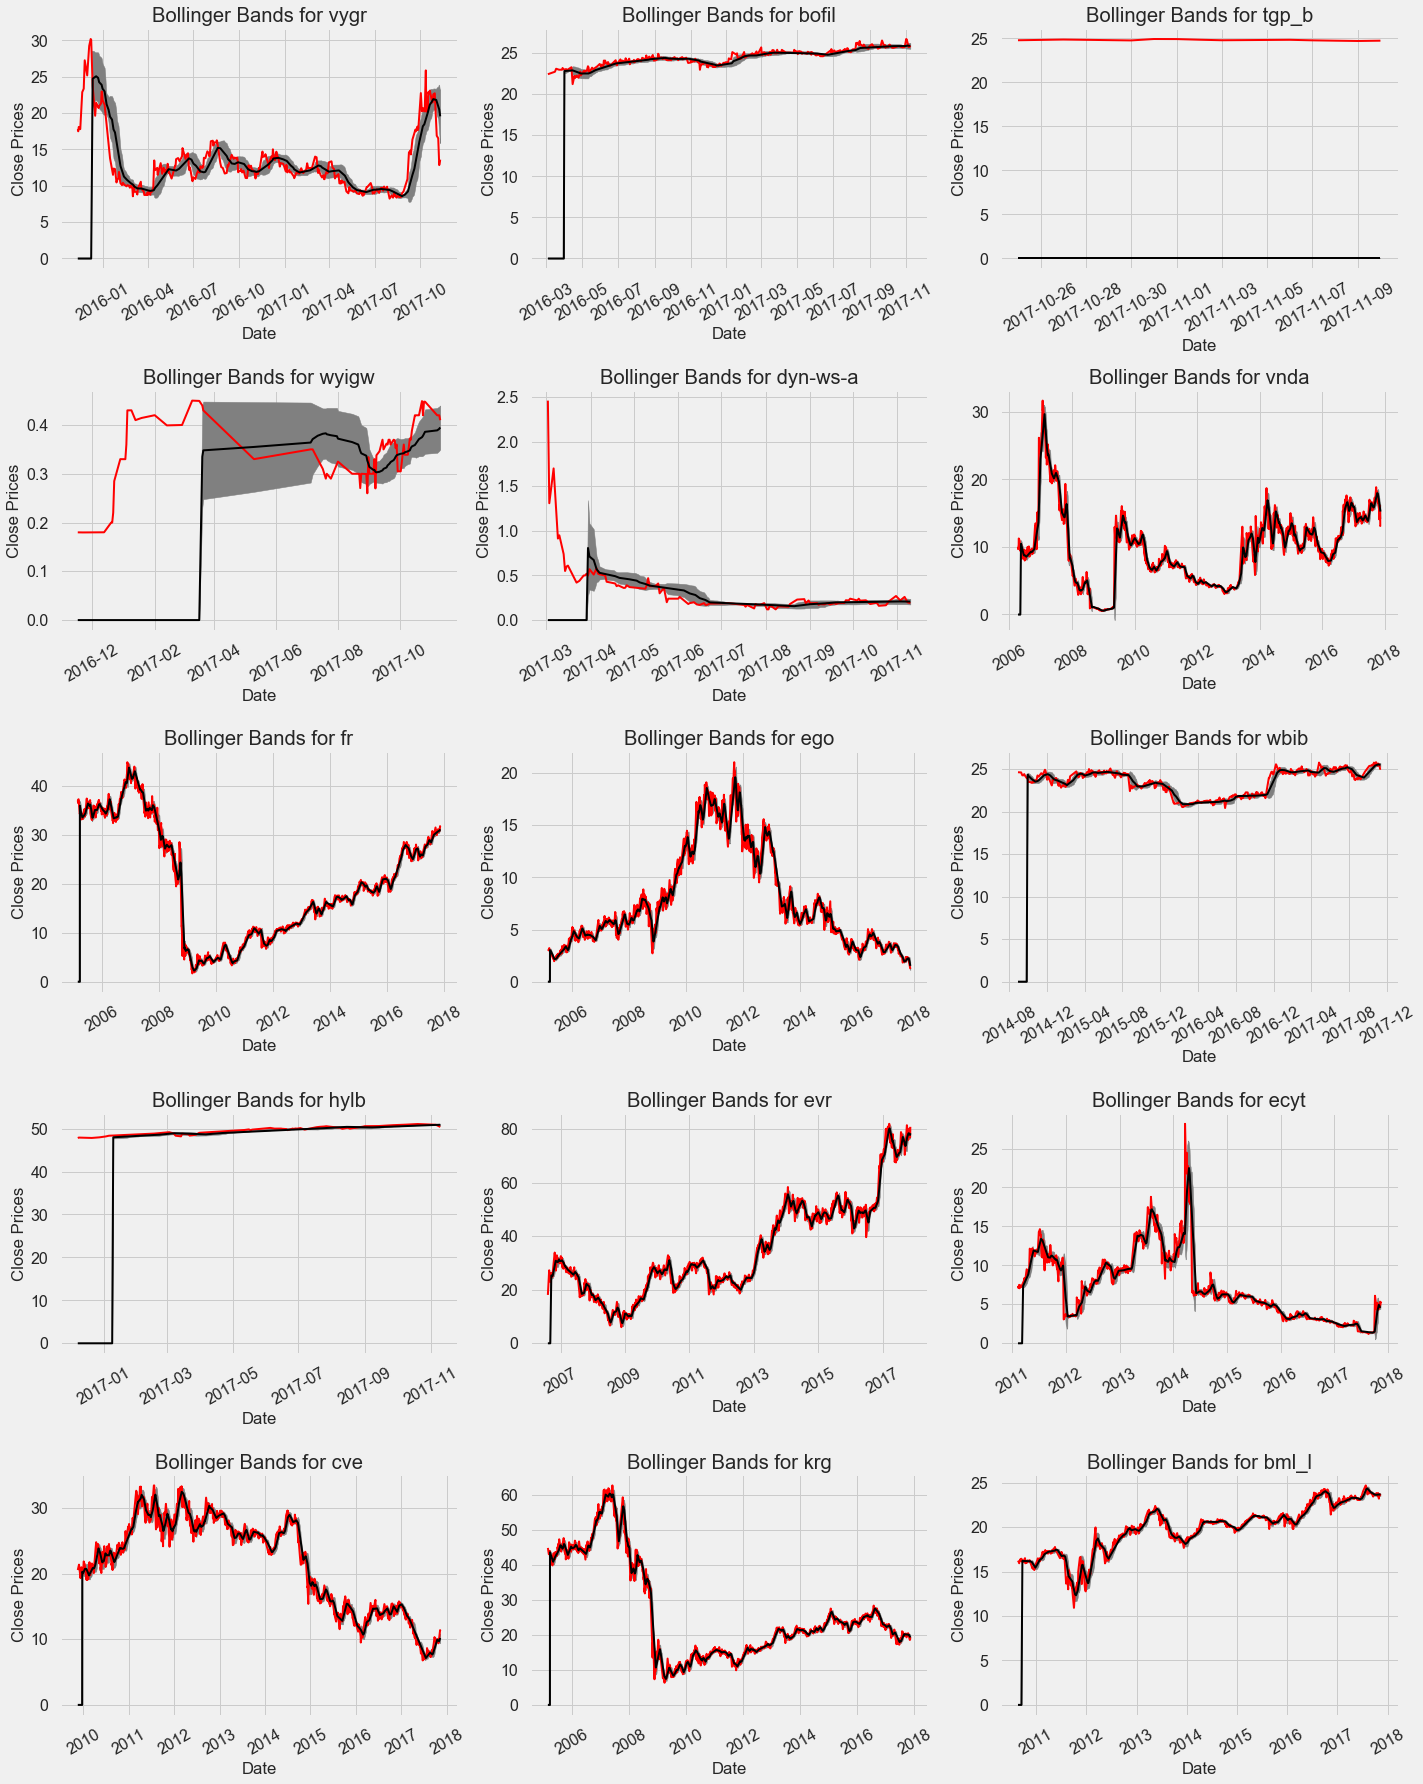

In [230]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(20,25))
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.fill_between(techindi1[i]['Date'].dt.to_pydatetime(), techindi1[i]['BB_Upper_Band'], techindi1[i]['BB_Lower_Band'], color='grey')
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(techindi1[i]['Date'], techindi1[i]['Close'], color='red', lw=2)
    ax.plot(techindi1[i]['Date'], techindi1[i]['BB_Middle_Band'], color='black', lw=2)
    ax.set_title("Bollinger Bands for " + str(techindi1[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()


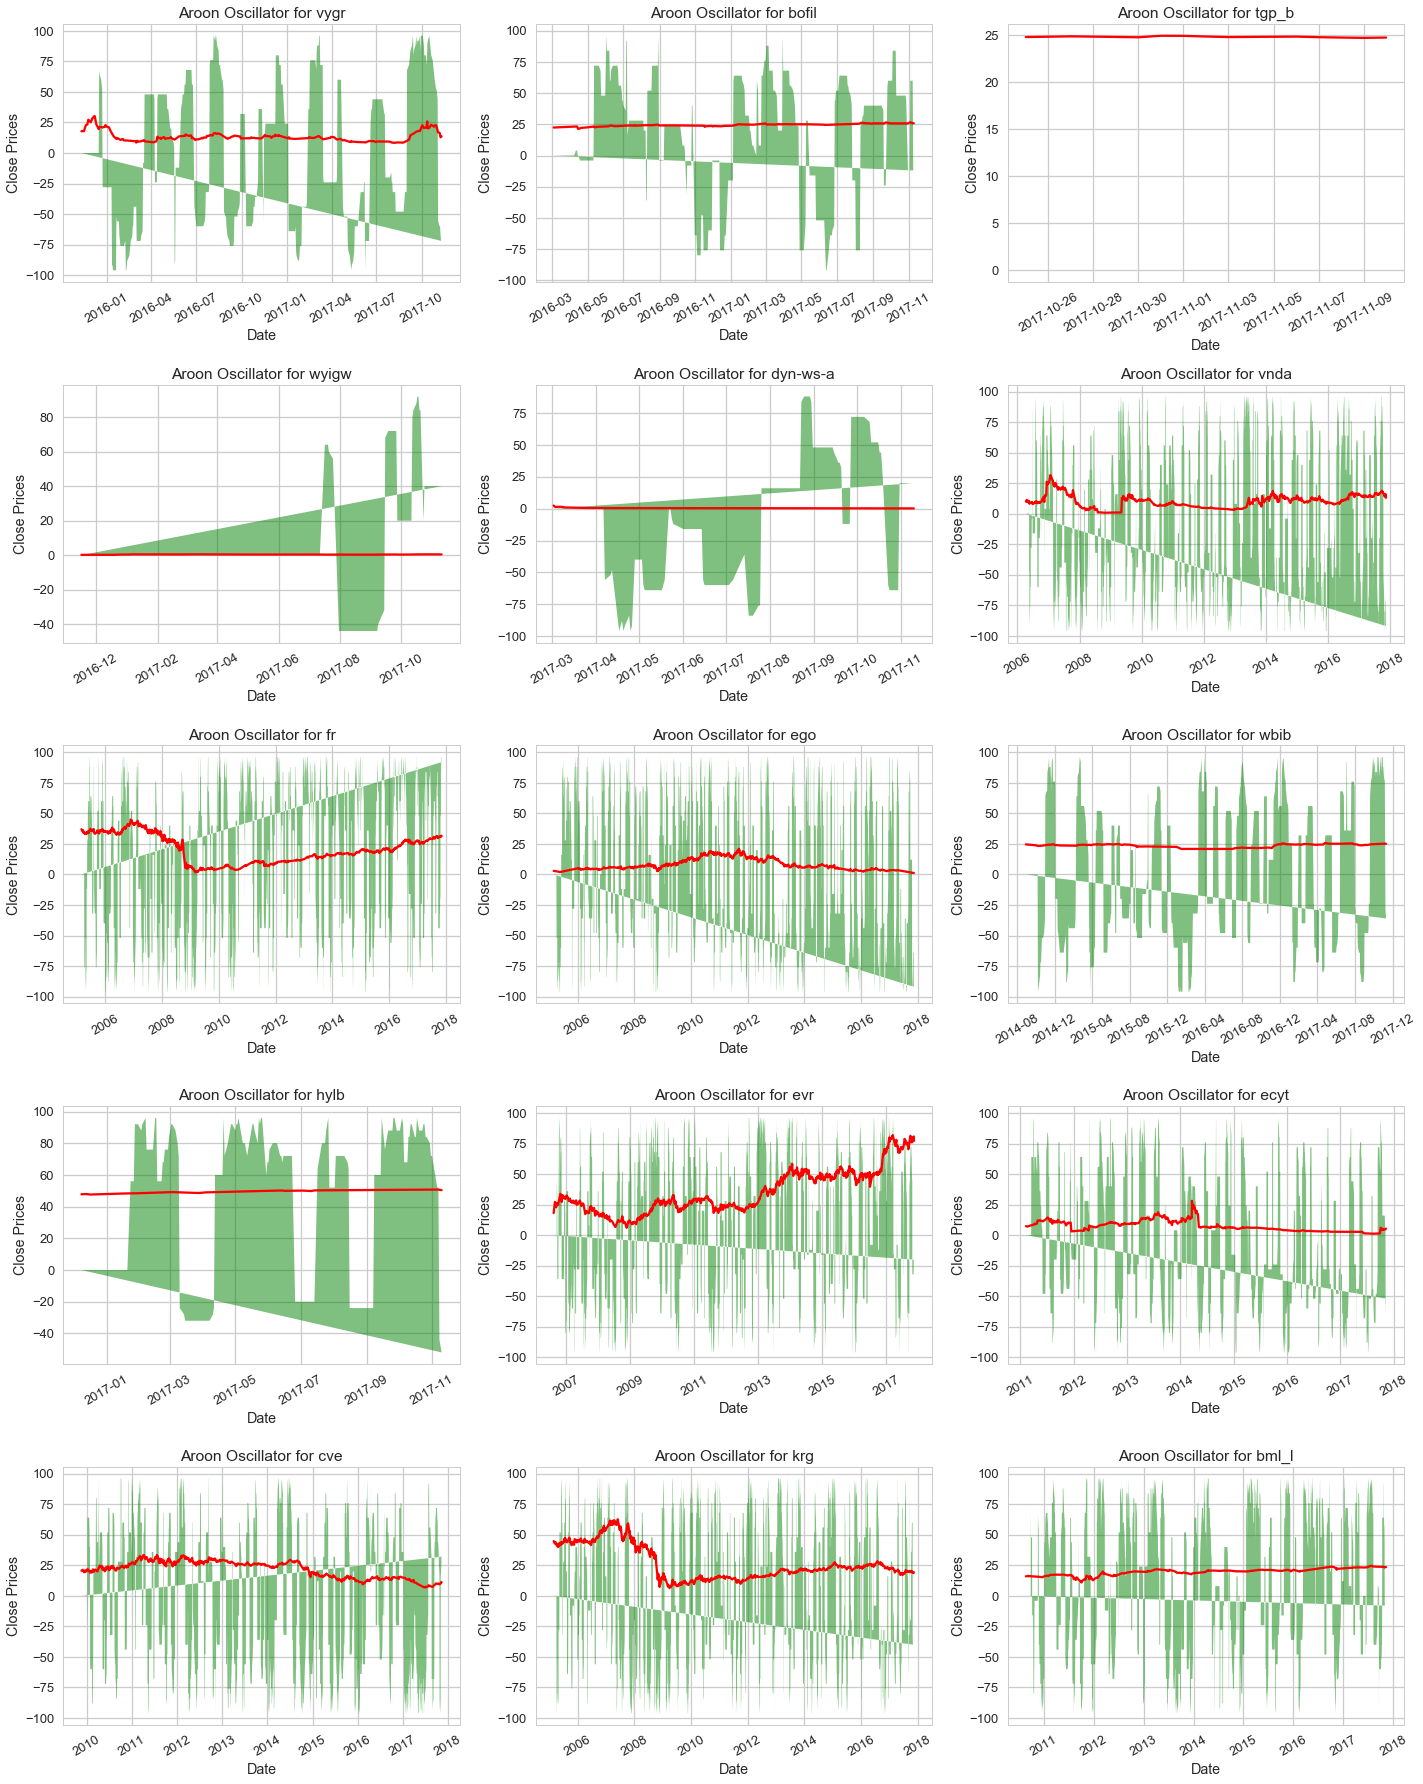

In [246]:
# Aroon Oscillator Plot
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,25))
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.fill(techindi1[i]['Date'].dt.to_pydatetime(), techindi1[i]['Aroon_Oscillator'],'g', alpha = 0.5)
    ax.plot(techindi1[i]['Date'], techindi1[i]['Close'], 'r')
    ax.set_title("Aroon Oscillator for " +str(techindi1[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

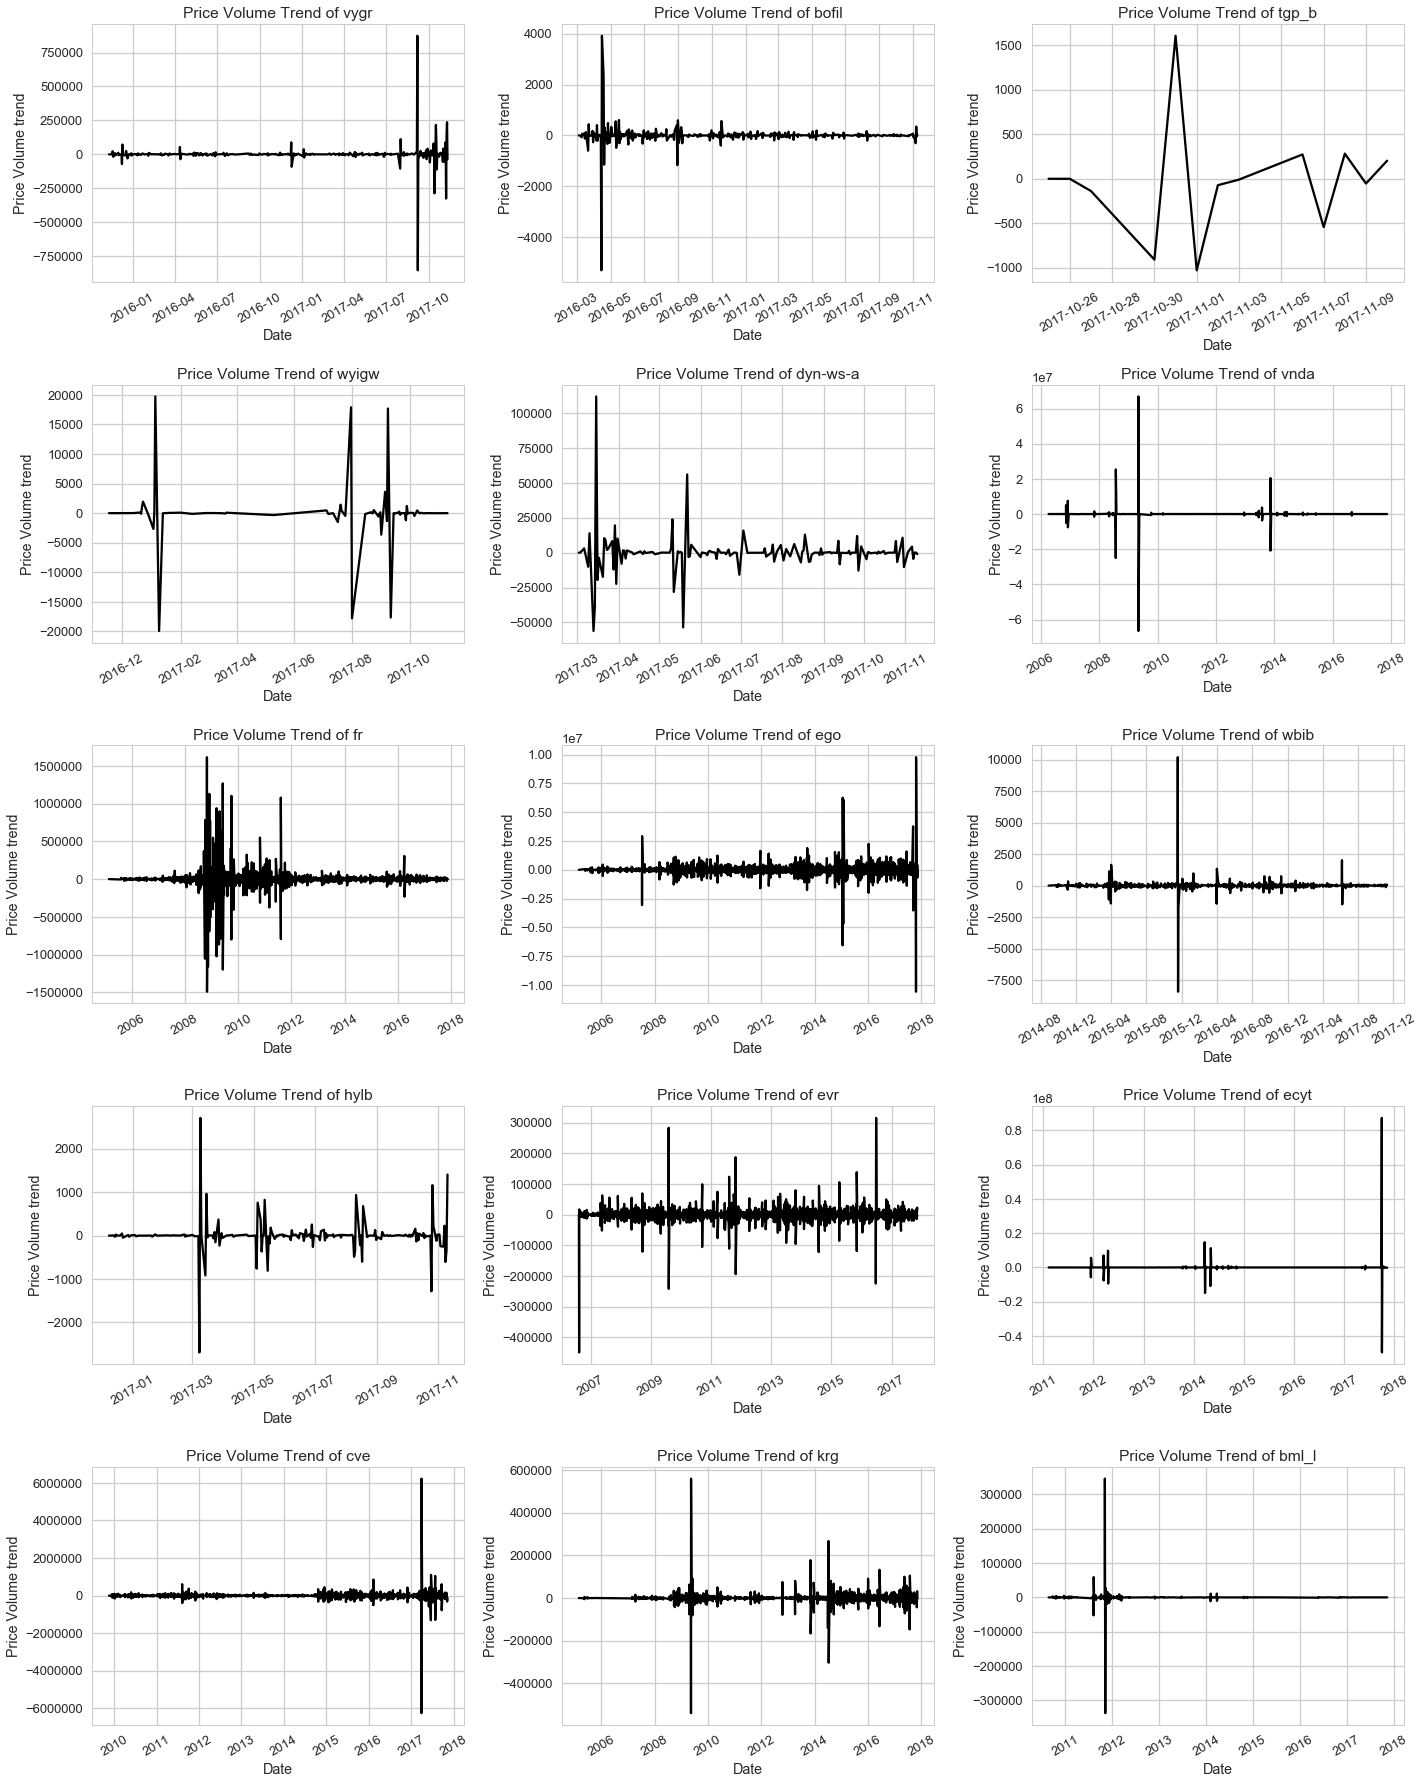

In [250]:
# PRice Volume Trend Plot
fig = plt.figure(figsize=(20,25))
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.plot(techindi1[i]['Date'], techindi1[i]['PVT'], 'black')
    ax.set_title("Price Volume Trend of " +str(techindi1[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price Volume trend")
    plt.xticks(rotation=30)
fig.tight_layout()

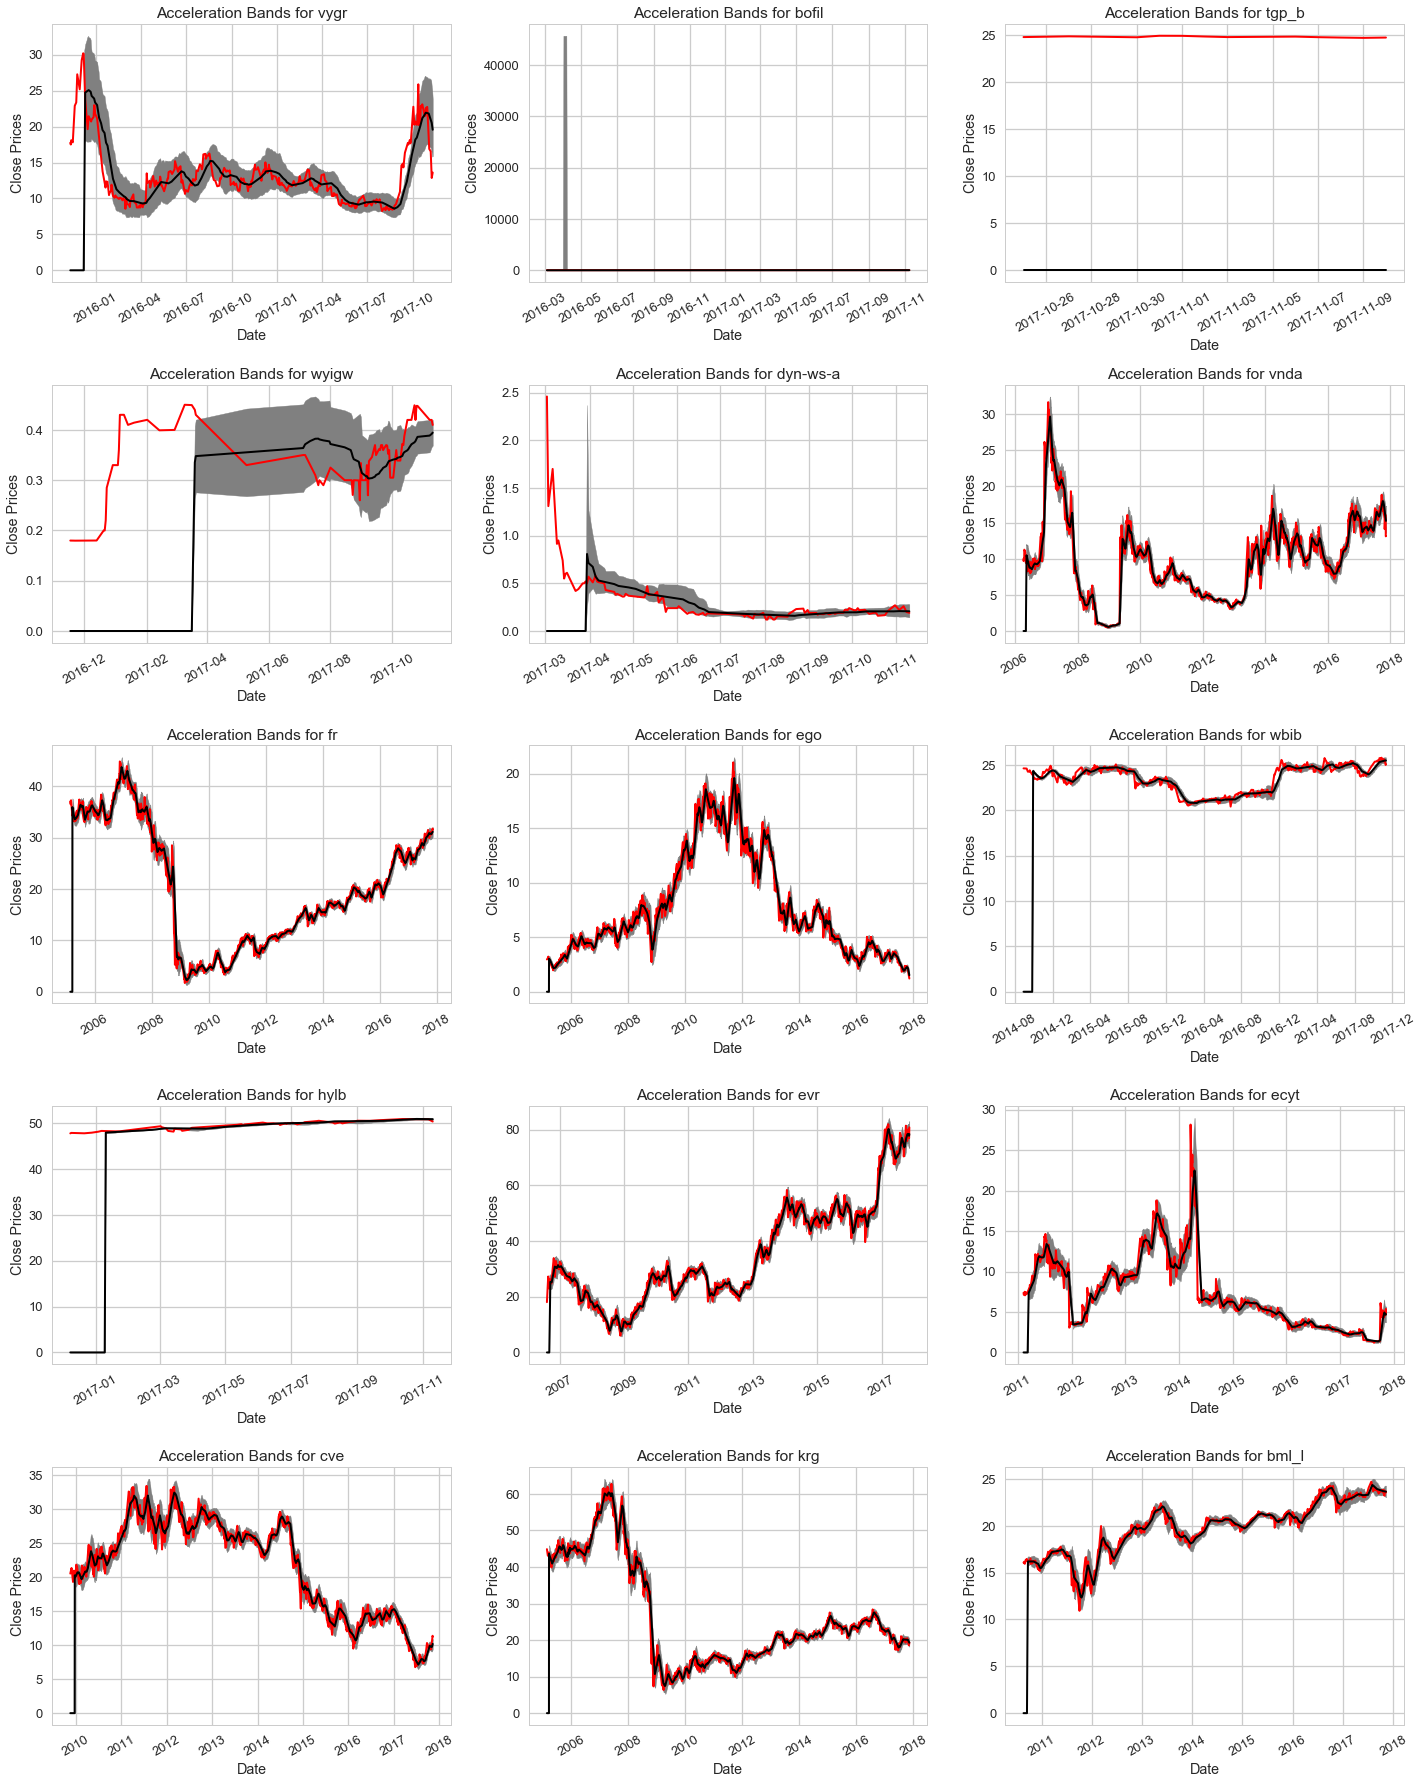

In [251]:
# Acceleration band Plot

fig = plt.figure(figsize=(20,25))
for i in range(15):
    ax = plt.subplot(5,3,i+1)
    ax.fill_between(techindi1[i]['Date'].dt.to_pydatetime(), techindi1[i]['AB_Upper_Band'], techindi1[i]['AB_Lower_Band'], color='grey')
    # Plot Adjust Closing Price and Moving Averages
    ax.plot(techindi1[i]['Date'], techindi1[i]['Close'], color='red', lw=2)
    ax.plot(techindi1[i]['Date'], techindi1[i]['AB_Middle_Band'], color='black', lw=2)
    ax.set_title("Acceleration Bands for " + str(techindi1[i]['Label'][0]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Prices")
    plt.xticks(rotation=30)
fig.tight_layout()

## Visualization of techindi2

In [252]:
techindi2[0].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP,Momentum
0,2015-11-11,15.10,17.93,14.75,17.750000,1261000,0,vygr,0.000000,0.0,0.0,17.750000,0.0,16.340000,0.000000
1,2015-11-12,17.75,18.03,17.40,17.500000,91900,0,vygr,0.000000,0.0,0.0,17.500000,0.0,16.433401,0.000000
2,2015-11-13,18.00,18.36,17.71,14.750000,26900,0,vygr,0.000000,0.0,0.0,14.750000,0.0,16.464625,0.000000
3,2015-11-16,17.83,18.10,17.75,14.894400,9300,0,vygr,24.861496,0.0,0.0,14.894400,0.0,16.474402,0.000000
4,2015-11-17,17.80,20.90,17.80,15.033024,13900,0,vygr,42.428571,0.0,0.0,15.033024,0.0,16.502892,-2.716976
